In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data = pd.read_excel('EPOC dataset.xlsx')

columns = ['metal','support','wt.%','ionic species','particle size(nm)','metal loading (mg)','CO2:H2 ratio','temp(℃)','rCO(mol/s)',
          'voltage(V)','ρCO','ΛCO']
data = data[columns]

# change string in data['metal'] into int with metal's atomic mass
data['metal'] = data['metal'].replace(['Fe','Co','Ni','Cu','ZnO','Ru','Rh','Pd','Pt'],
                                      ['55.8','58.9','58.7','63.5','65.4','101.1','102.9','106.4','195.1']).astype(float)

# change string in data['wt.%'] into int, where 100: no support
data['wt.%'] = data['wt.%'].fillna(100).astype(float)


# change string in data['CO2:H2 ratio'] into int by calculating the ratios
data['gas ratio'] = data['CO2:H2 ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))

# delete the data['CO2:H ratio'] column, which has been converted into data['gas ratio']
data = data.drop('CO2:H2 ratio', axis=1)

# change the columns' names into abbreviations, where M:metal, S:support, WT.%:wt.%, IS:ionic species, PS:particle size,
# ML:metal loading, T: temperature, RR:reaction rate, V:applied potential, ρ:enhancement ratio, Λ:Faradaic efficiency, GR:gas ratio
data.columns = ['M','S','WT','IS','PS','L','T','RR','V','ρ','Λ','GR']

#determine the ionic charge
ionic_charge = {
    'O2-': -2,
    'H+': 1,
    'Li+': 1,
    'Na+': 1,
    'K+': 1,
    'none': 0
}
data['IS_charge'] = data['IS'].replace(ionic_charge).fillna(0).astype(float)

# define a function to make a classification for EPOC behavior based on the applied potential and ρ values
# 0: electrophobic, 1: electrophilic
def electro_class(row):
    if row['V'] > 0 and row['ρ'] >= 1:
        return 0
    elif row['V'] < 0 and row['ρ'] >= 1:
        return 1
    elif row['V'] > 0 and row['ρ'] <= 1:
        return 1
    elif row['V'] < 0 and row['ρ'] <= 1:
        return 0
    else:
        return 'undefined'

# create a new column named 'BH' (EPOC behavior)
data['BH'] = data.apply(electro_class, axis=1)


# determine the columns that are used as features in classification
features = ['M', 'L', 'V', 'T', 'GR']

X = data[features].copy()
y = data['ρ']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

[0.3110202034209406, 0.31102020231257466, 0.3110200916134874, 0.31100915781027516, 0.3100388663367666, 0.27072240483040744]
[0.41402564318950164, 0.414025626595813, 0.4140253280881503, 0.4140092646763792, 0.4127023291482027, 0.3600848577906359]
[0.5286833683286138, 0.52868336917911, 0.5286834541232064, 0.5286918440933327, 0.529436389821701, 0.5596055753379545]
[0.4664940067293167, 0.46649401993954714, 0.46649425758140634, 0.46650704565861784, 0.46754749663397194, 0.5094362495329223]


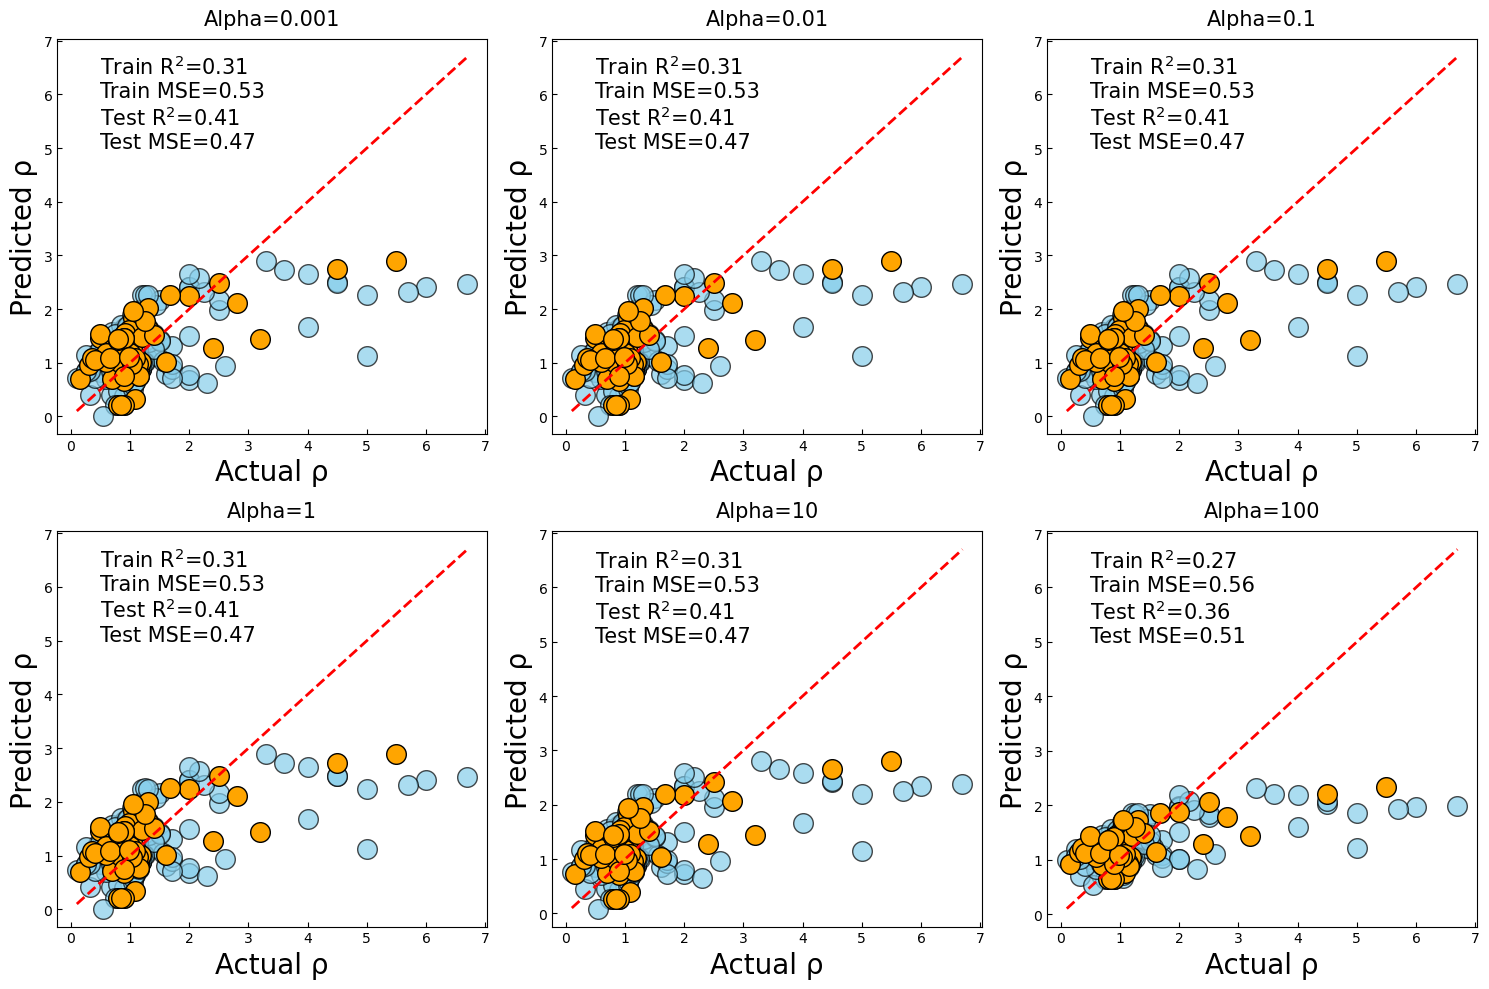

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

alphas = [0.001, 0.01, 0.1, 1, 10, 100]  # Regularization strength; must be a positive float

fig, subaxes = plt.subplots(2, 3, figsize=(15, 10))

all_train_r2 = []
all_test_r2 = []
test_mse_all=[]
train_mse_all=[]

for i, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha, random_state=0)
    ridge.fit(X_train, y_train)
    y_predict = ridge.predict(X_test)
    y_predict_train = ridge.predict(X_train)

    subaxes[i // 3, i % 3].scatter(y_train, y_predict_train, s=200, alpha=0.7, edgecolors='black', c='skyblue')
    subaxes[i // 3, i % 3].scatter(y_test, y_predict, s=200, edgecolors='black', c='orange')
    subaxes[i // 3, i % 3].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    subaxes[i // 3, i % 3].set_title(f'Alpha={alpha}', pad=10, fontsize=15)
    subaxes[i // 3, i % 3].set_xlabel('Actual ρ', size=20)
    subaxes[i // 3, i % 3].set_ylabel('Predicted ρ', size=20)

    train_score = ridge.score(X_train, y_train)
    test_score = ridge.score(X_test, y_test)
    mse_test = mean_squared_error(y_test, y_predict)
    mse_train = mean_squared_error(y_train, y_predict_train)
    all_train_r2.append(train_score)
    all_test_r2.append(test_score)
    test_mse_all.append(mse_test)
    train_mse_all.append(mse_train)

    subaxes[i // 3, i % 3].text(0.5, 5, f'Train R$^{2}$={train_score:.2f}\nTrain MSE={mse_train:.2f}\nTest R$^{2}$={test_score:.2f}\nTest MSE={mse_test:.2f}', fontsize=15)
    subaxes[i // 3, i % 3].tick_params(which='both', direction='in', labelsize=10)

print(all_train_r2)
print(all_test_r2)
print(train_mse_all)
print(test_mse_all)

plt.tight_layout()
plt.show()

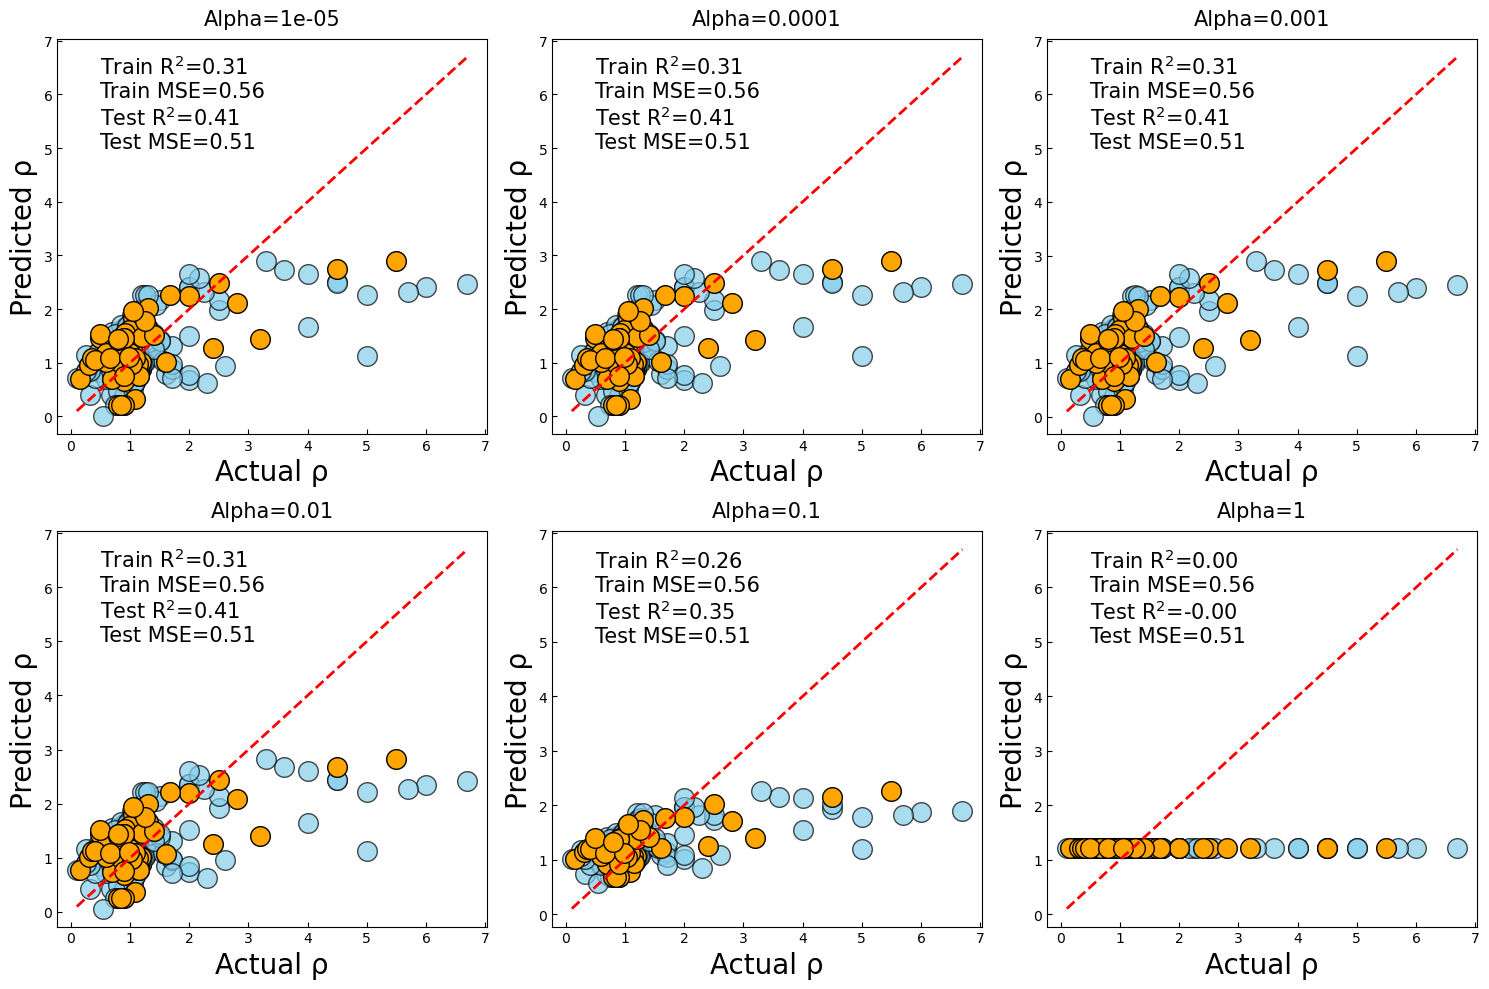

In [3]:
from sklearn.linear_model import Lasso

alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]  # Regularization strength; must be a positive float

fig, subaxes = plt.subplots(2, 3, figsize=(15, 10))
    
for i, alpha in enumerate(alphas):
    lasso = Lasso(alpha=alpha, random_state=0)
    lasso.fit(X_train, y_train)
    y_predict = lasso.predict(X_test)
    y_predict_train = lasso.predict(X_train)

    subaxes[i // 3, i % 3].scatter(y_train, y_predict_train, s=200, alpha=0.7, edgecolors='black', c='skyblue')
    subaxes[i // 3, i % 3].scatter(y_test, y_predict, s=200, edgecolors='black', c='orange')
    subaxes[i // 3, i % 3].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    subaxes[i // 3, i % 3].set_title(f'Alpha={alpha}', pad=10, fontsize=15)
    subaxes[i // 3, i % 3].set_xlabel('Actual ρ', size=20)
    subaxes[i // 3, i % 3].set_ylabel('Predicted ρ', size=20)

    train_score = lasso.score(X_train, y_train)
    test_score = lasso.score(X_test, y_test)
    train_mse = mean_squared_error(y_train, y_predict_train)
    test_mse = mean_squared_error(y_test, y_predict)
    subaxes[i // 3, i % 3].text(0.5, 5, f'Train R$^{2}$={train_score:.2f}\nTrain MSE={mse_train:.2f}\nTest R$^{2}$={test_score:.2f}\nTest MSE={mse_test:.2f}', fontsize=15)
    subaxes[i // 3, i % 3].tick_params(which='both', direction='in', labelsize=10)

plt.tight_layout()
plt.show()

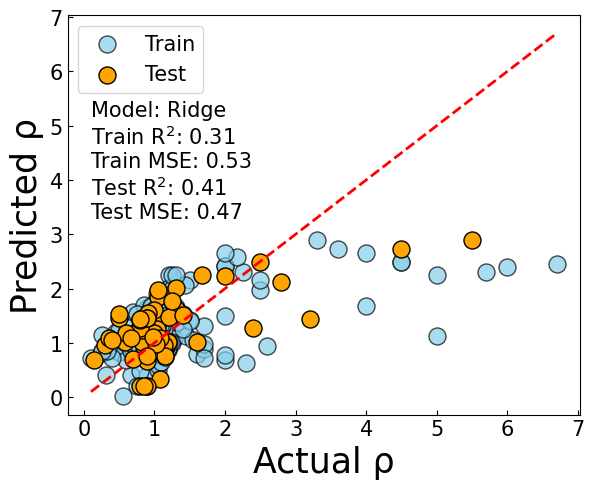

In [4]:
# Best Linear Regression
from sklearn.linear_model import Ridge

RR_best = Ridge(alpha=1, random_state=0)
RR_best.fit(X_train, y_train)

y_predict = RR_best.predict(X_test)
y_predict2 = RR_best.predict(X_train)

train_score = RR_best.score(X_train, y_train)
test_score = RR_best.score(X_test, y_test)
train_mse = mean_squared_error(y_train, y_predict2)
test_mse = mean_squared_error(y_test, y_predict)

fig1 = plt.figure(figsize=(6,5))
plt.scatter(y_train, y_predict2, s=150, c='skyblue', alpha=0.7, label='Train', edgecolors='black')
plt.scatter(y_test, y_predict, s=150, c='orange', label='Test', edgecolors='black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual ρ', size=25)
plt.ylabel('Predicted ρ', size=25)
plt.text(0.1, 3.3, f'Model: Ridge\nTrain R$^{2}$: {train_score:.2f}\nTrain MSE: {train_mse:.2f}\nTest R$^{2}$: {test_score:.2f}\nTest MSE: {test_mse:.2f}', fontsize=15)
plt.legend(loc='best', fontsize=15, frameon=True)
plt.tick_params(which='both', direction='in', labelsize=15)
plt.tight_layout()
plt.savefig('RR Actual vs. Predicted.jpg', format='jpeg', dpi=600)
plt.show()

Using 244 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/61 [00:00<?, ?it/s]

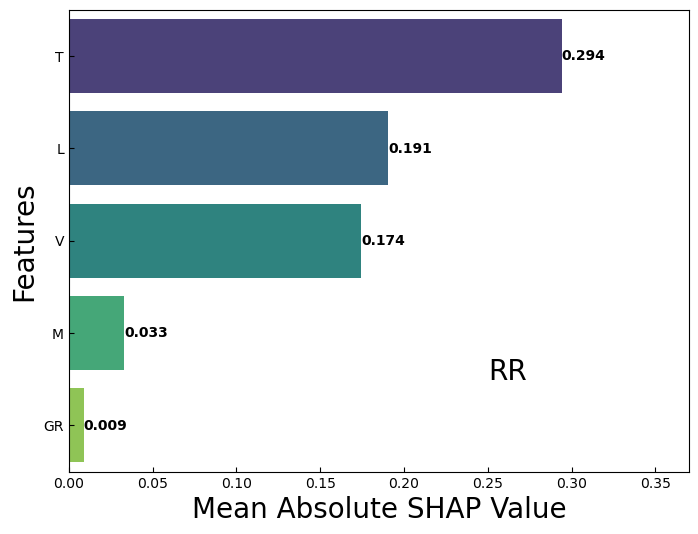

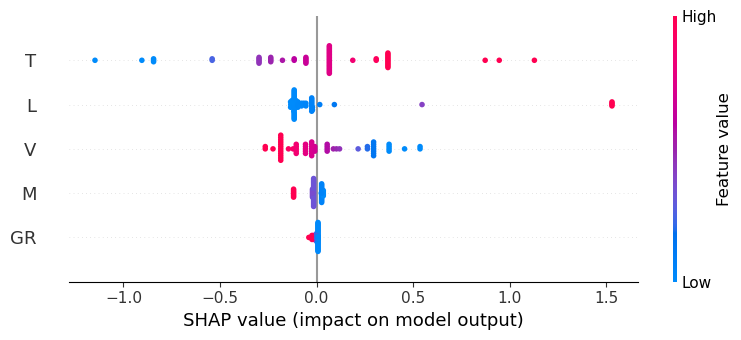

In [5]:
# use SHAP to explain and visualize the feature importance
import shap
shap.initjs()
# Creating the KernelExplainer
RR_explainer = shap.KernelExplainer(RR_best.predict, X_train)
RR_shap_values = RR_explainer.shap_values(X_test)

# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(RR_shap_values), axis=0)

# Create a DataFrame for plotting with SHAP values
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances with values
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center', ha='left', color='black', fontweight='bold')

plt.xlim(0, 0.37)
plt.xlabel('Mean Absolute SHAP Value', size=20)
plt.ylabel('Features', size=20)
plt.tick_params(which='both', direction='in', labelsize=10)
plt.text(0.25, len(importance_df) - 1.5, 'RR', fontsize=20)
plt.savefig('RR_SHAP.jpg', format='jpeg', dpi=600)
plt.show()

# Generating the summary plot showing the distribution of SHAP values for each feature
shap.summary_plot(RR_shap_values, X_test, feature_names=X.columns)